## Tidytuesday Tweets

* [Dave Robinson's analysis](https://github.com/dgrtwo/data-screencasts/blob/master/tidytuesday-tweets.Rmd)

Takeaways:

* qgrid does not like when a dataframe has columns containing lists
* need efficient categorical reordering...
* `%whos DataFrame` is very handy!

In [1]:
from siuba import *

from plotnine import *
import plotnine as p

import pandas as pd

import rpy2.ipython
%load_ext rpy2.ipython

import rpy2.robjects as robjects

import qgrid
qgrid.set_defaults(grid_options = {"forceFitColumns": False})

## Load in Data

I'm using rpy2 3.0, but its conversion to a pandas DataFrame doesn't seem to work, if
it is a list column with a NULL entry.

See [rtweet](https://rtweet.info/) for explanation of data.

* row - a tweet
* col - various measures

In [2]:
%%R -o tt_tweets
library(readr)

tt_tweets <- read_rds(url("https://github.com/rfordatascience/tidytuesday/blob/master/data/2019/2019-01-01/tidytuesday_tweets.rds?raw=true"))

tt_tweets <- as.list(tt_tweets)

In [3]:
out = {}
for k, col in tt_tweets.items():
    out[k] = robjects.pandas2ri.rpy2py_listvector(col)

df = pd.DataFrame(out)

# to_datetime wants nanoseconds by default, but gets to the second...
df["created_at"] = pd.to_datetime(df.created_at, unit = "s")

## Quick glimpse of raw data

In [4]:
df[["user_id", "created_at", "hashtags", "favorite_count", "retweet_count"]].head()

,user_id,created_at,hashtags,favorite_count,retweet_count
0,161366031,2018-12-19 05:41:40,[tidytuesday],0,0
1,161366031,2018-12-12 05:43:24,[tidytuesday],7,1
2,161366031,2018-12-17 02:15:24,[tidytuesday],5,1
3,3181988029,2018-12-19 01:12:56,[tidytuesday],2,0
4,470648737,2018-12-19 00:32:07,"[BeckyG, TidyTuesday]",0,0


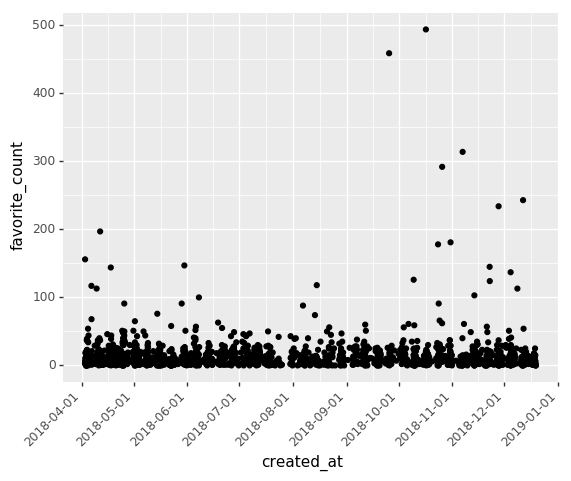

<ggplot: (314191147)>

In [5]:
ggplot(df, aes("created_at", "favorite_count")) \
  + geom_point() \
  + theme(axis_text_x = element_text(angle=45, ha = "right"))

## Weekly likes and retweets

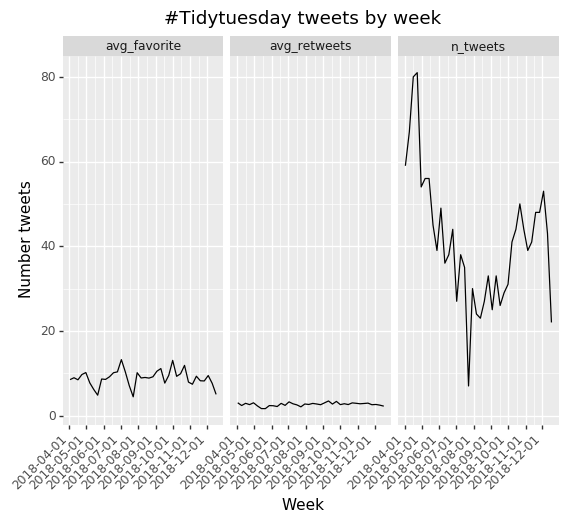

<ggplot: (317057863)>

In [6]:
# number of tweets per week
# week floor: https://medium.com/jbennetcodes/dealing-with-datetimes-like-a-pro-in-pandas-b80d3d808a7f
# plotnine them options: https://plotnine.readthedocs.io/en/stable/api.html#themeables

# this allows these functions to be used in siu expressions
from siuba.meta_hook.numpy import log, exp

week_summary = (df
  >> mutate(_, week = _.created_at.dt.to_period("W").dt.start_time)
  >> group_by(_, "week")
  >> summarize(_,
       n_tweets = _.shape[0],
       # geometric means of vals + 1
       avg_retweets = exp(log(_.retweet_count + 1).mean()),
       avg_favorite = exp(log(_.favorite_count + 1).mean())
     )
  )

(week_summary
  >> pipe(_.melt(id_vars = "week"))
  >> ggplot(aes("week", "value"))
   + geom_line()
   + theme(axis_text_x = element_text(angle=45, ha = "right"))
   + facet_wrap("~ variable")
   + labs(title = "#Tidytuesday tweets by week", y = "Number tweets", x = "Week")
  )


In [7]:
week_summary

,week,n_tweets,avg_retweets,avg_favorite
0,2018-04-02,59,3.031357,8.497609
1,2018-04-09,67,2.380566,8.941072
2,2018-04-16,80,2.902267,8.455548
3,2018-04-23,81,2.597064,9.700304
4,2018-04-30,54,3.025615,10.170684
5,2018-05-07,56,2.279093,7.733034
6,2018-05-14,56,1.658016,6.177933
7,2018-05-21,45,1.644790,4.820913
8,2018-05-28,39,2.363629,8.640204
9,2018-06-04,49,2.329797,8.551762


## Who is tweeting most?

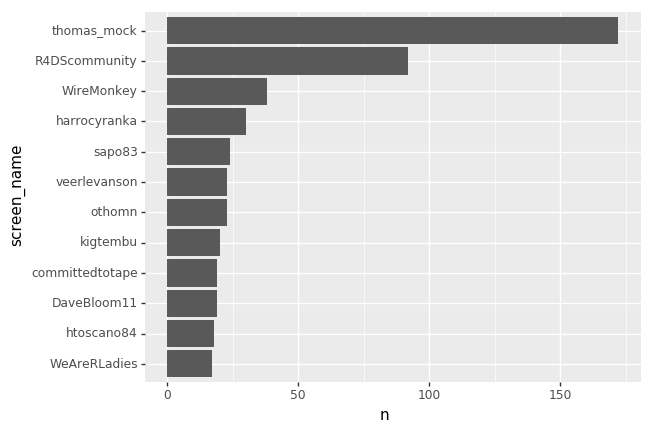

<ggplot: (-9223372036537643772)>

In [8]:
from siuba.meta_hook.pandas import Categorical

(df
  >> count(_, "screen_name", sort = True)
  >> head(_, 12)
  # compare with reorder(screen_name, n)
  >> mutate(_, screen_name = Categorical(_.screen_name, _.screen_name.iloc[::-1], ordered = True))
  >> ggplot(aes("screen_name", "n"))
   + geom_col()
   + coord_flip()
  )

## Who is getting most retweets?

In [9]:
(df
  >> group_by(_, "screen_name") 
  >> summarize(_, tweets = _.shape[0], retweets = _.retweet_count.sum())
  >> arrange(_, -_.tweets, -_.retweets)
  >> head(_, 10)
  )

,screen_name,tweets,retweets
453,thomas_mock,172,729
144,R4DScommunity,92,250
202,WireMonkey,38,126
286,harrocyranka,30,104
422,sapo83,24,64
465,veerlevanson,23,121
385,othomn,23,54
326,kigtembu,20,37
231,committedtotape,19,84
43,DaveBloom11,19,61


In [10]:
df \
  >> select(_, "screen_name", "text", "retweet_count", "favorite_count") \
  >> mutate(_, ratio = (_.favorite_count + 1) / (_.retweet_count + 1)) \
  >> arrange(_, -_.ratio) \
  >> head(_, 10)

,screen_name,text,retweet_count,favorite_count,ratio
955,hadleywickham,@drob Do a #tidytuesday !,0,61,62.0
47,isbrutussick,.@drob can’t say enough what an incredible pub...,0,25,26.0
813,EvaMaeRey,"One Monday of ""core tidyverse"" package downloa...",0,23,24.0
1451,jblewis49,My first #TidyTuesday submission. I am new to...,0,23,24.0
415,thomas_mock,For #TidyTuesday this week I have to side with...,0,18,19.0
1122,thomasp85,"Since there is no weekday starting with ""A"" th...",1,35,18.0
1188,cs_teitelbaum,Looks like even Portlanders aren't immune to r...,0,16,17.0
1344,markdaku,"Not a lot of time this morn, but some quick gr...",0,16,17.0
1318,_LouiseRP,My first go at #TidyTuesday and (gasp) first e...,1,32,16.5
1412,JCMassante,After six Tuesdays reading #TidyTuesday contri...,0,15,16.0


## tidytext analyses

In [11]:
from nltk.tokenize import TweetTokenizer

# make and test tokenizer
tknzr = TweetTokenizer()
s0 = df.loc[0, 'text']
tknzr.tokenize(s0)

def tokenize(s):
    return pd.DataFrame({'word': tknzr.tokenize(s)})

all_tweet_words = df \
  >> mutate(_, data = _.text.apply(tokenize)) \
  >> unnest(_, "data")

# count number of times the word "in" appears. Need to use stopwords!
all_tweet_words.word.value_counts()['in']

558

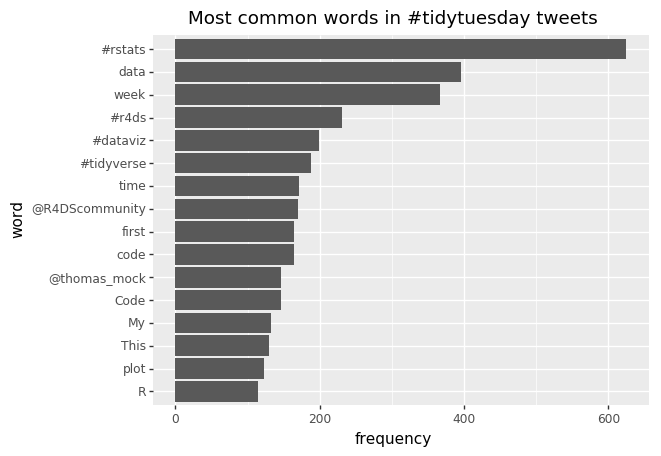

<ggplot: (-9223372036536105072)>

In [12]:
# stopwords: see https://stackoverflow.com/a/19133088/1144523
from nltk.corpus import stopwords

stop_en = set(stopwords.words('english'))
stop_en.update(["#TidyTuesday", "#tidytuesday", "de", "I"])

tweet_words = all_tweet_words \
  >> filter(_, ~_.word.isin(stop_en), _.word.str.contains("[a-zA-Z]")) \
  >> mutate(_, week = _.created_at.dt.to_period("W").dt.start_time)

(tweet_words
  >> count(_, _.word, sort = True)
  >> head(_, 16)
  >> mutate(_, word = Categorical(_.word, _.word.iloc[::-1], ordered = True))
  >> ggplot(aes("word", "n"))
   + geom_col()
   + coord_flip()
   + labs(title = "Most common words in #tidytuesday tweets", y = "frequency")
  )

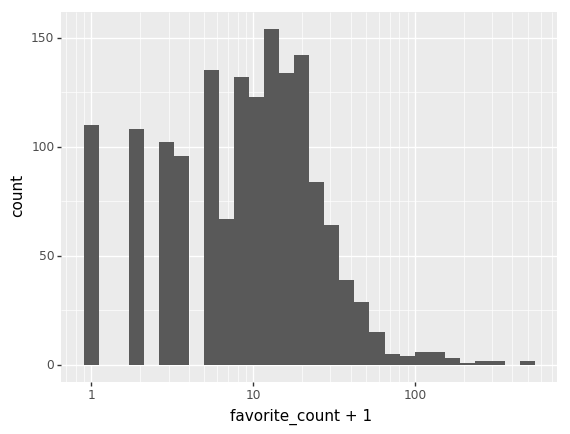

<ggplot: (-9223372036536087727)>

In [13]:
(df
  >> ggplot(aes("favorite_count + 1"))
   + geom_histogram(bins = 30)
   + scale_x_log10()
  )

## What topic is each week about?

In [14]:
# use tf_idf on weekly words
from sklearn.feature_extraction.text import TfidfTransformer

tf_idf = TfidfTransformer()

# convert to week x word frequency counts
# note: not a sparse matrix, use sklearn's CountVectorizer for that
week_word_freq = tweet_words \
  >> count(_, "week", "word") \
  >> spread(_, "word", "n", fill = 0, reset_index = False)

# get week x word tf-idf measures
tf_idf.fit(week_word_freq)
word_tf_idf = tf_idf.transform(week_word_freq).toarray()

# do some serious munging to go back to long format
tmp = pd.DataFrame(word_tf_idf, index = week_word_freq.index, columns=week_word_freq.columns)
tmp[tmp == 0] = pd.np.nan
long_tf_idf = tmp.stack().reset_index() >> rename(_, word = "level_1", tf_idf = 0)

top_word = (tweet_words
  >> inner_join(_, long_tf_idf, ["week", "word"])
  >> arrange(_, -_.tf_idf)
  >> distinct(_, "week", _keep_all = True)
  >> select(_, _.week, _.tf_idf, _.startswith(""))
  )



In [15]:
top_word \
  >> inner_join(_, week_summary, ["week"]) \
  >> arrange(_, -_.avg_retweets)

,week,tf_idf,word,user_id,status_id,created_at,screen_name,text,source,display_text_width,...,verified,profile_url,profile_expanded_url,account_lang,profile_banner_url,profile_background_url,profile_image_url,n_tweets,avg_retweets,avg_favorite
8,2018-09-10,0.455189,dogs,122462547,1039505744385720320,2018-09-11 13:27:37,harrocyranka,#TidyTuesday week 24. Decided to cluster state...,Twitter Web Client,258.0,...,0,NA,NA,en,NA,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1070137590...,33,3.458113,11.110522
10,2018-09-24,0.404363,species,122462547,1044582983200473088,2018-09-25 13:42:45,harrocyranka,#tidytuesday week 26. Invasive species by Afri...,Twitter Web Client,260.0,...,0,NA,NA,en,NA,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1070137590...,29,3.356631,9.490794
2,2018-07-02,0.491469,expectancy,3229475660,1014688035089321985,2018-07-05 01:50:54,iamasharkskin,#TidyTuesday after a long time! This time visu...,Twitter Web Client,236.0,...,0,https://t.co/TomPHSm1yR,http://kanishka.xyz,en,https://pbs.twimg.com/profile_banners/32294756...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/8591224800...,27,3.245094,13.222196
31,2018-04-02,0.218818,#rstats,15231924,981639213186678784,2018-04-04 21:06:41,WireMonkey,Used https://t.co/fCLxYKVDTw\n#TidyTuesday to ...,Twitter Web Client,131.0,...,0,NA,NA,en,https://pbs.twimg.com/profile_banners/15231924...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/9087404596...,59,3.031357,8.497609
27,2018-04-30,0.274903,Community,983470194982088704,991010304984272896,2018-04-30 17:44:03,R4DScommunity,"Welcome to #TidyTuesday week 5, let's explore ...",Twitter for iPhone,276.0,...,0,NA,NA,en,https://pbs.twimg.com/profile_banners/98347019...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/9851639084...,54,3.025615,10.170684
28,2018-09-03,0.248400,food,122462547,1037026035370520580,2018-09-04 17:14:08,harrocyranka,#TidyTuesday week 23. Was feeling a bit advent...,Twitter Web Client,239.0,...,0,NA,NA,en,NA,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1070137590...,25,3.017485,10.481833
0,2018-10-22,0.502057,movies,970554068899790848,1055062261788639234,2018-10-24 11:43:39,DaveBloom11,#TidyTuesday Week 30 - Movie Profit\n\nAlthoug...,Twitter Web Client,244.0,...,0,https://t.co/Rcmr8oqtWR,http://dave-bloom.com,en,https://pbs.twimg.com/profile_banners/97055406...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/9705572527...,50,3.004222,11.861352
14,2018-11-19,0.384662,Thanksgiving,161366031,1064937573833859072,2018-11-20 17:44:37,Eeysirhc,What this suggests to me is 1) West Coast folk...,Twitter Web Client,163.0,...,0,http://t.co/XCsPiUABTH,http://www.christopheryee.org,en,https://pbs.twimg.com/profile_banners/16136603...,http://abs.twimg.com/images/themes/theme9/bg.gif,http://pbs.twimg.com/profile_images/9410606207...,48,2.946630,8.229026
9,2018-10-29,0.412493,downloads,122462547,1057261840705769472,2018-10-30 13:24:00,harrocyranka,#tidytuesday week 31. Similar patterns for R d...,Twitter Web Client,217.0,...,0,NA,NA,en,NA,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1070137590...,44,2.908850,7.916576
24,2018-04-16,0.279379,death,3229475660,986390601477345285,2018-04-17 23:47:00,iamasharkskin,My first submission to #TidyTuesday that shows...,Twitter Web Client,205.0,...,0,https://t.co/TomPHSm1yR,http://kanishka.xyz,en,https://pbs.twimg.com/profile_banners/32294756...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/8591224800...,80,2.902267,8.455548


## Scrape titles from github

In [16]:
# TODO